In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import zipfile
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/dejavusans-bold/DejaVuSans-Bold.ttf
/kaggle/input/sentiment-analysis-on-movie-reviews/sampleSubmission.csv
/kaggle/input/sentiment-analysis-on-movie-reviews/train.tsv.zip
/kaggle/input/sentiment-analysis-on-movie-reviews/test.tsv.zip


In [2]:
dataset_path = "/kaggle/working/"
font = "/kaggle/input/dejavusans/DejaVuSans-Bold.ttf"

## Extract zip files

In [3]:
def extract_file(path):
    with zipfile.ZipFile(path,'r') as zipref:
        zipref.extractall('./data')

In [4]:
paths = [
    '/kaggle/input/sentiment-analysis-on-movie-reviews/train.tsv.zip',
    '/kaggle/input/sentiment-analysis-on-movie-reviews/test.tsv.zip', 
]
_ = [extract_file(path) for path in paths]

# Explore Data

In [5]:
df = pd.read_csv('./data/train.tsv', sep='\t')
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


**The sentiment labels are:**
* 0 - negative
* 1 - somewhat negative
* 2 - neutral
* 3 - somewhat positive
* 4 - positive

In [6]:
df['Sentiment'].unique()

array([1, 2, 3, 4, 0])

## Distribution sentiment classes

### Plot handlers

In [7]:
def shpw_distplot(_df, feature):
    plt.figure(figsize=(8, 6))
    sns.distplot(_df[feature], bins=10, kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.show()

In [8]:
def generate_wordcloud(all_words, feature, label="Most used words in"):
    # Generate word cloud
    wordcloud = WordCloud(width = 1000, height = 500, font_path=f'{font}/DejaVuSans-Bold.ttf').generate(' '.join(all_words))

    # Plot word cloud
    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud)
    plt.title(f"{label} {feature}", size=16)
    plt.axis("off")
    plt.show()

In [9]:
def show_word_ferq(_df, feature, top_words=10):
  # Get the top 10 most common words
  words = ' '.join(_df[feature]).split()
  word_counts = Counter(words)
  top_words = word_counts.most_common(top_words)

  # Separate the words and their counts
  words, counts = zip(*top_words)

  # Create the bar plot
  fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), sharex=True)
  ax1.bar(words, counts)
  ax1.set_title(f"{feature} Word Frequency")

  ax2.bar(words, np.log10(counts))
  ax2.set_title(f"{feature} Word Frequency (Log10 Adjusted)")
  plt.show()

In [10]:
def getAllWords(_df, feature):
    return pd.Series(' '.join(str(_df[feature]).split()))

In [11]:
def show_sentiment_distribution(_df, feature):
    # Count the occurrences of each unique sentiment category
    sentiment_counts = _df[feature].value_counts()

    # Create a pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title('Sentiment Distribution')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    # Show the pie chart
    plt.show()

**Distribution Plot for Sentiment**

In [12]:
feature_target = 'Sentiment'

/tmp/ipykernel_26/19030082.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(_df[feature], bins=10, kde=True)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


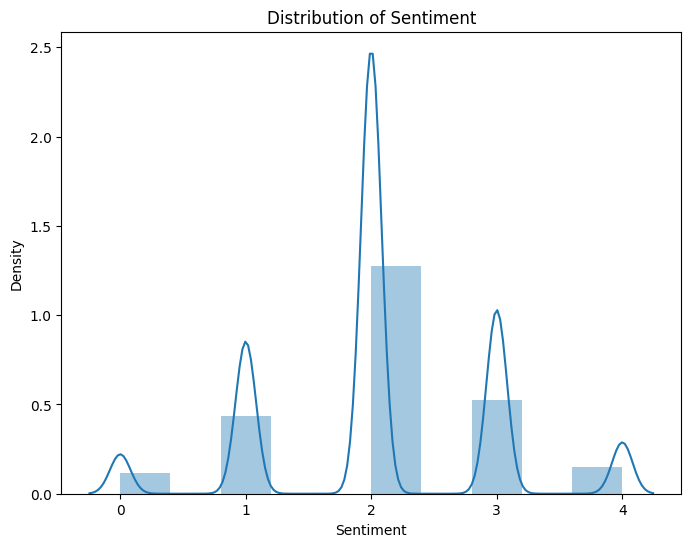

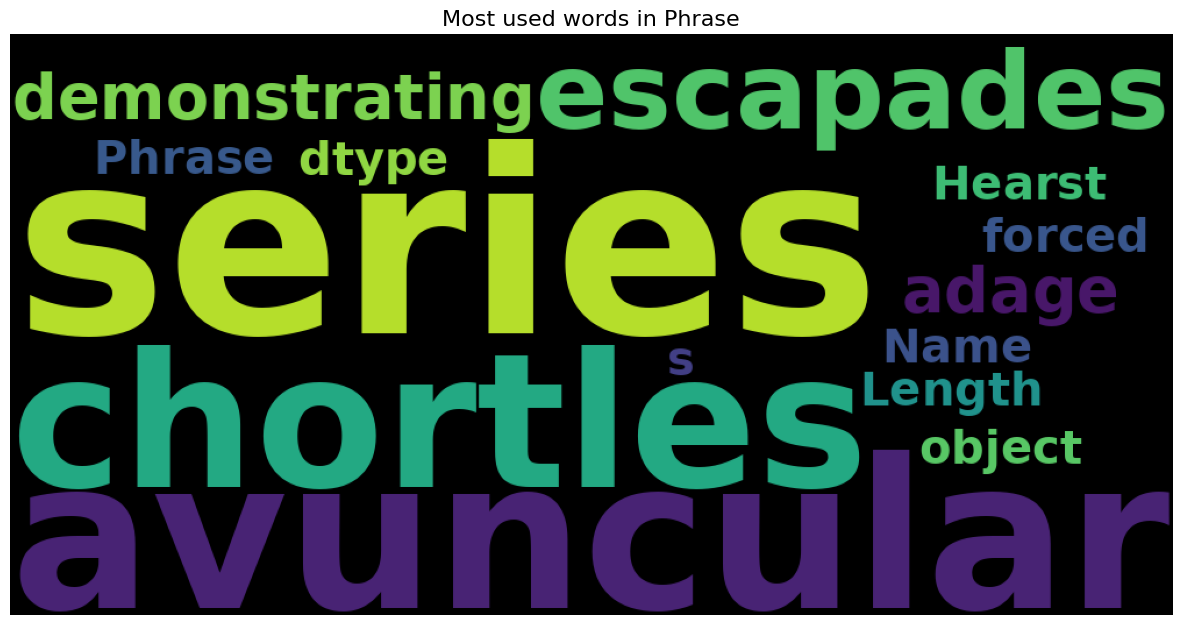

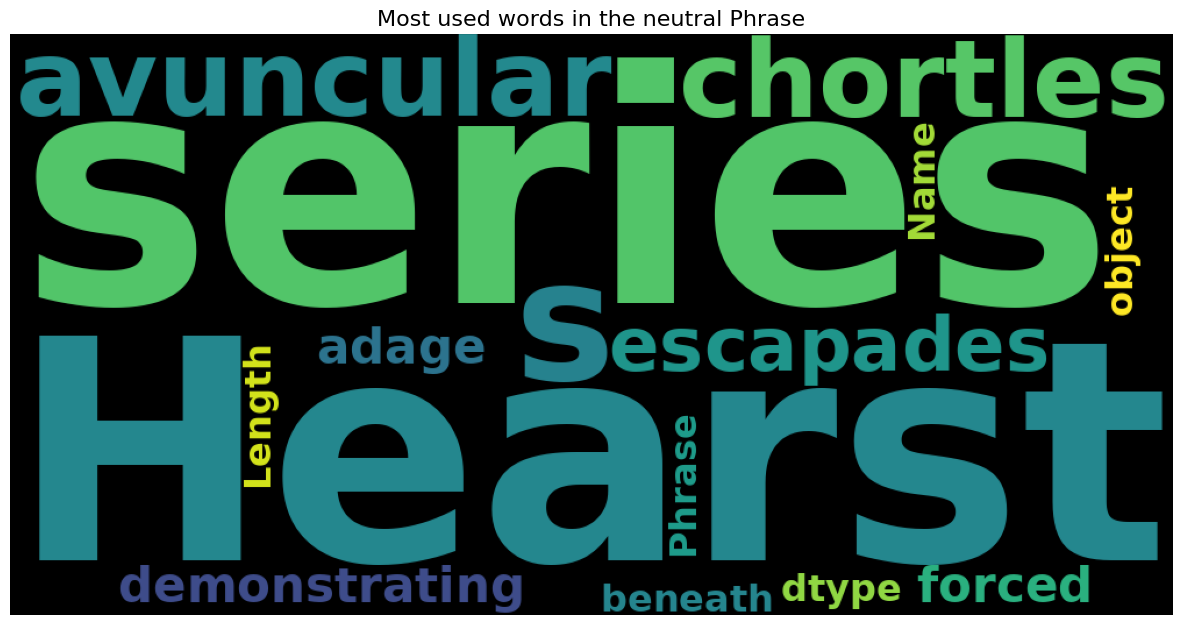

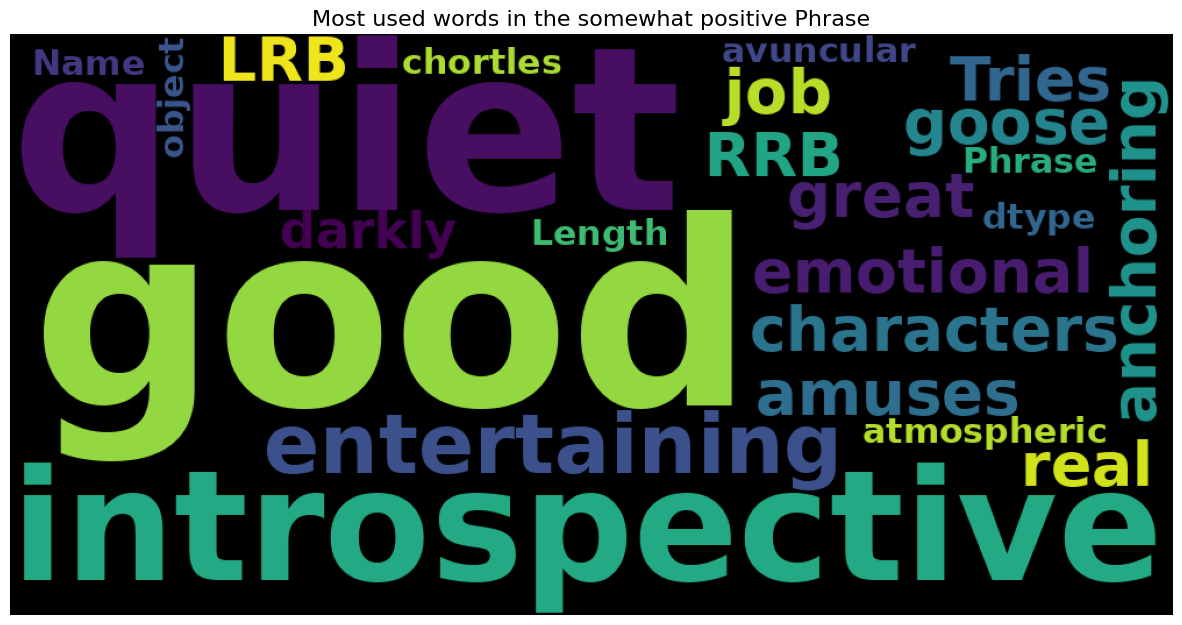

In [13]:
shpw_distplot(df, feature_target)

# get all words for phrase column
all_words = getAllWords(df, 'Phrase')

# show the word cloud
generate_wordcloud(all_words, 'Phrase')

# get all words for neutral
all_words_neutral = getAllWords(df[df[feature_target] == 2], 'Phrase')

# show the word cloud for neutral
generate_wordcloud(all_words_neutral, 'Phrase', 'Most used words in the neutral')

# get all words for somewhat positive
all_words_somewhat_positive = getAllWords(df[df[feature_target] == 3], 'Phrase')

# show the word cloud for neutral
generate_wordcloud(all_words_somewhat_positive, 'Phrase', 'Most used words in the somewhat positive')

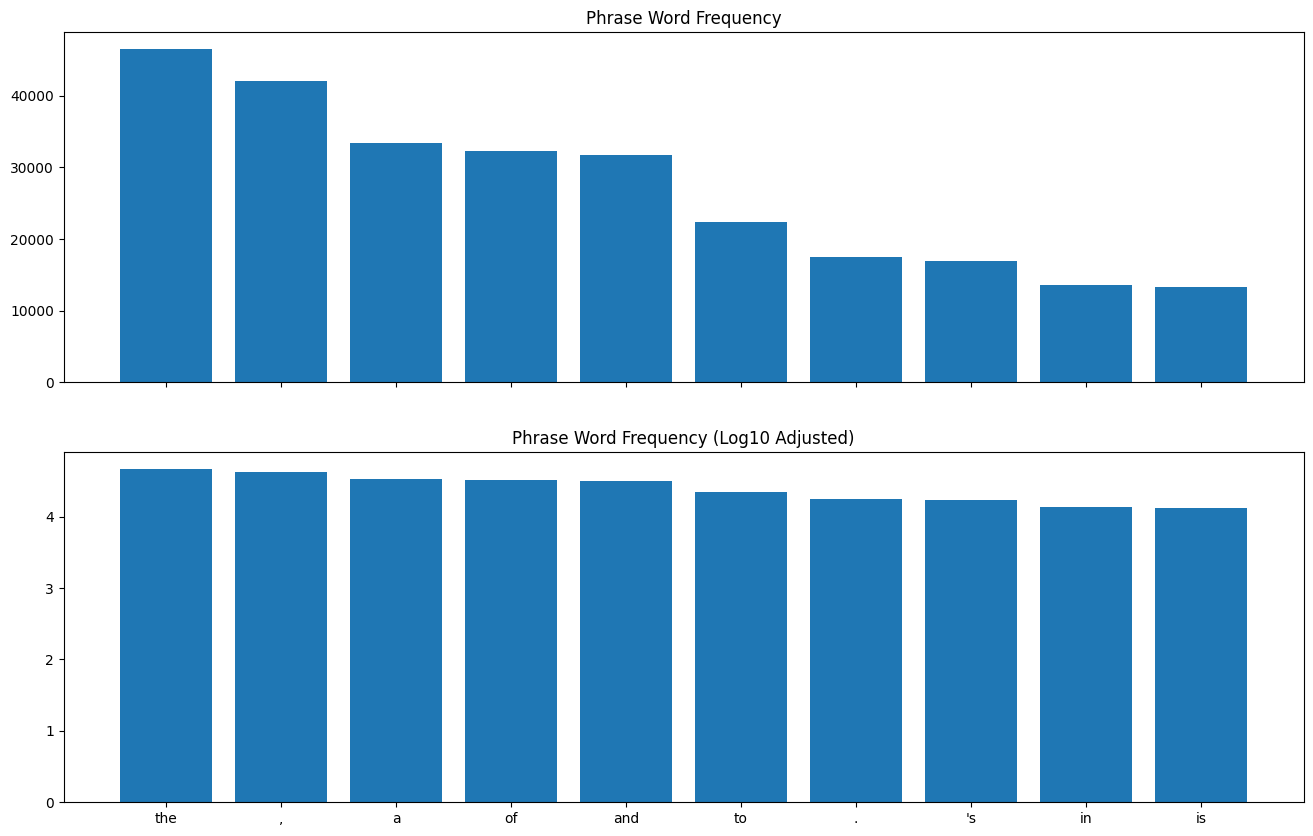

In [14]:
show_word_ferq(df, 'Phrase')

we can see that there is ',' and '.' we should remove the stop words to see the words correctly

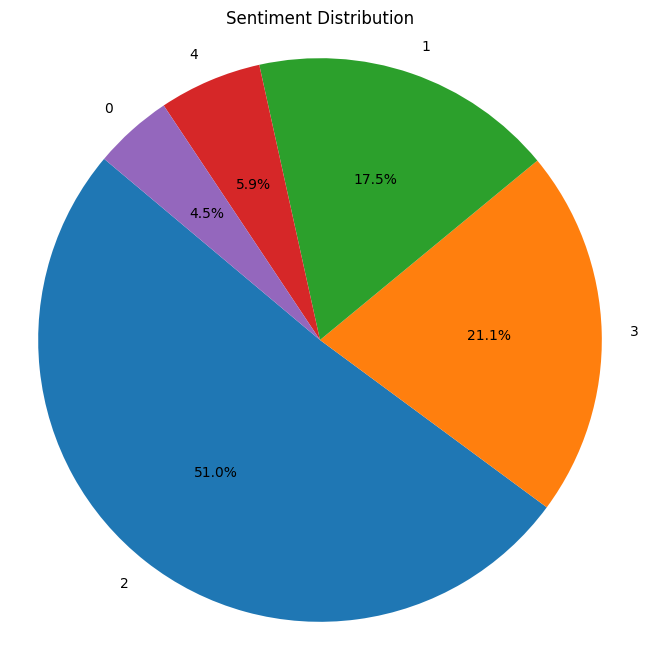

In [15]:
show_sentiment_distribution(df, feature_target)

# Preprocess Data

## Preprocess utils handlers

### Check for nan handler

In [16]:
# check_for_nan for many features
def check_for_nan(_df, features=[]):
    [print(f"{feature} has {_df[feature].isnull().sum()} nan") for feature in features]

### Remove stop words handler

In [17]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download the stop words
nltk.download('stopwords')
nltk.download('punkt')

# Get the stop words for Arabic and English
stop_words = stopwords.words('english')

# Function to remove stop words from a string
def remove_stop_words(text):
    tokens = word_tokenize(text)
    filtered = [word for word in tokens if word.casefold() not in stop_words]
    return ' '.join(filtered)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Most common word handler

In [18]:
def get_common_word(_df, feature):
  from collections import Counter
  reviews_without_null = _df[_df[feature].notnull()][feature]
  # Get the most common word in 'feature'
  words = pd.Series(' '.join(reviews_without_null).lower().split())
  return Counter(words).most_common(1)[0][0]

**check features for nan**

In [19]:
features_labels = ['Phrase', 'Sentiment','SentenceId','PhraseId']
check_for_nan(df, features_labels)

Phrase has 0 nan
Sentiment has 0 nan
SentenceId has 0 nan
PhraseId has 0 nan


**apply stop words handler**

In [20]:
df['Phrase'] = df['Phrase'].apply(remove_stop_words)

**Check most common word**

In [21]:
most_common_word_review = get_common_word(df, 'Phrase')
print(most_common_word_review)

,


## Create two tensors (inputs IDs, Attension Mak)

In [22]:
seq_len = 512
num_samples = len(df)

In [23]:
num_samples, seq_len

(156060, 512)

In [24]:
from transformers import BertTokenizer, AutoModel
model_name = 'bert-base-cased'

**Create the tokenizer**

In [25]:
tokenizer = BertTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

**get the tokens**

In [26]:
tokens = tokenizer(df['Phrase'].tolist(), 
                   max_length=seq_len,
                   padding='max_length',
                   truncation=True,
                   add_special_tokens=True,
                   return_tensors='np'
                  )

In [27]:
tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [28]:
tokens['input_ids']

array([[  101,  1326, 13936, ...,     0,     0,     0],
       [  101,  1326, 13936, ...,     0,     0,     0],
       [  101,  1326,   102, ...,     0,     0,     0],
       ...,
       [  101,   170, 25247, ...,     0,     0,     0],
       [  101,   170, 25247, ...,     0,     0,     0],
       [  101, 22572, 12148, ...,     0,     0,     0]])

In [29]:
type(tokens['attention_mask'])

numpy.ndarray

## File Handlers

**Save file**

In [30]:
def saveFile(name, file):
    with open(name,'wb') as f:
        np.save(f, file)

**read file**

In [31]:
def readFile(filename: str):
    with open(filename, 'rb') as f:
        return np.load(f, allow_pickle=True)

## Save the Sentiment labels in binary file

In [32]:
sentimentArr = df['Sentiment'].values

In [33]:
labels = np.zeros((num_samples, sentimentArr.max()+1))
labels.shape

(156060, 5)

In [34]:
files_list = (
    {'list' : tokens['input_ids'], 'key': 'xids'},
    {'list' : tokens['attention_mask'], 'key': 'xmask'},
    {'list':labels, 'key':'labels'}
)

## Save the tensors and the labels as numpy binary files

In [35]:
_ = [saveFile(f"./data/movie-{item['key']}.npy", item['list']) for item in files_list]

# Input Pipeline

In [36]:
payload = {}
for file in files_list:  
    payload[file['key']] =  readFile(f"./data/movie-{file['key']}.npy")

In [37]:
payload['xids'].shape, payload['xmask'].shape, payload['labels'].shape

((156060, 512), (156060, 512), (156060, 5))

In [38]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split, Subset,RandomSampler

**CustomDataset Class**

In [39]:
class CustomDataset(Dataset):
    def __init__(self, inputIds, attention_mask, labels):
        self.inputIds = inputIds
        self.attention_mask = attention_mask
        self.labels = labels

    def __getitem__(self, idx):
        item = {
            "inputIds": self.inputIds[idx],
            "attention_mask": self.attention_mask[idx],
            "labels": self.labels[idx]
        }
        return item

    def __len__(self):
        return len(self.labels)

**Save DataLoader**

In [40]:
def save_loader(_loader, filename):
    torch.save(_loader, filename)

**Load DataLoader**

In [41]:
def load_loader(_loader, filename):
    return torch.load(filename)

**Convert numpy arrays to PyTorch tensors**

In [42]:
inputIds_tensor = torch.from_numpy(payload['xids'])
attention_mask_tensor = torch.from_numpy(payload['xmask'])
labels_tensor = torch.from_numpy(payload['labels'])

**Create a TensorDataset**

In [43]:
dataset = CustomDataset(inputIds_tensor, attention_mask_tensor, labels_tensor)

In [44]:
dataset.__getitem__(1)

{'inputIds': tensor([  101,  1326, 13936, 25265, 16913, 15107,  8050,  2553,  1363, 20398,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,    

**Generate & shuffle indices**

In [45]:
dataset_len = len(dataset)
indices = torch.randperm(dataset_len)

**Define size of train/test indices**

In [46]:
train_size = int(0.8* dataset_len)
test_size = len(dataset) - train_size

**Select train/test**

In [47]:
train_indices = indices[:train_size]
test_indices = indices[:test_size]

train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

**Parameters**

In [48]:
batch_size = 16

**Create DataLoaders for train and test**

In [49]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=RandomSampler(train_dataset))
test_loader = DataLoader(test_dataset, batch_size=batch_size, sampler=RandomSampler(test_dataset))

**Save Loaders**

In [50]:
save_loader(train_loader, 'train_loader')
save_loader(test_loader, 'test_loader')

**Load Loaders**

In [51]:
train_loader = load_loader(train_loader, 'train_loader')
test_loader = load_loader(test_loader, 'test_loader')

# Build and train

In [52]:
!pip install torch-summary

In [53]:
from torchsummary import summary

**Load the base BERT model**

In [54]:
bert_model = AutoModel.from_pretrained(model_name)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

**Sentiment Classifier Class**

In [55]:
class SentimentClassifier(nn.Module):
    def __init__(self, bert_model, num_classes):
        super().__init__()
        # Initialize the BERT model
        self.bert_model = bert_model
        # Initialize a linear layer for classification. The input size is the hidden size of the BERT model
        # and the output size is the number of classes.
        self.classifier = nn.Linear(bert_model.config.hidden_size, num_classes)
        
    def forward(self, input_ids, attention_mask):
        # Feed the inputs through the BERT model. The 'attention_mask' is used to ignore padding tokens
        outputs = self.bert_model(input_ids=input_ids, attention_mask=attention_mask)
        # The 'pooler_output' is a summary of the content, according to the BERT model
        # Feed the 'pooler_output' through the classifier to get the logits
        logits = self.classifier(outputs.pooler_output)
        return logits


**Create an instance of the sentiment classifier**

In [56]:
model = SentimentClassifier(bert_model, num_classes=5)

In [57]:
summary(model)

Layer (type:depth-idx)                   Param #
├─BertModel: 1-1                         --
|    └─BertEmbeddings: 2-1               --
|    |    └─Embedding: 3-1               22,268,928
|    |    └─Embedding: 3-2               393,216
|    |    └─Embedding: 3-3               1,536
|    |    └─LayerNorm: 3-4               1,536
|    |    └─Dropout: 3-5                 --
|    └─BertEncoder: 2-2                  --
|    |    └─ModuleList: 3-6              85,054,464
|    └─BertPooler: 2-3                   --
|    |    └─Linear: 3-7                  590,592
|    |    └─Tanh: 3-8                    --
├─Linear: 1-2                            3,845
Total params: 108,314,117
Trainable params: 108,314,117
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─BertModel: 1-1                         --
|    └─BertEmbeddings: 2-1               --
|    |    └─Embedding: 3-1               22,268,928
|    |    └─Embedding: 3-2               393,216
|    |    └─Embedding: 3-3               1,536
|    |    └─LayerNorm: 3-4               1,536
|    |    └─Dropout: 3-5                 --
|    └─BertEncoder: 2-2                  --
|    |    └─ModuleList: 3-6              85,054,464
|    └─BertPooler: 2-3                   --
|    |    └─Linear: 3-7                  590,592
|    |    └─Tanh: 3-8                    --
├─Linear: 1-2                            3,845
Total params: 108,314,117
Trainable params: 108,314,117
Non-trainable params: 0

**Move model to GPU if available**

In [58]:
# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

**Freeze the BERT model**

In [59]:
# Freeze the BERT model
for param in model.bert_model.parameters():
    param.requires_grad = False

**Define the loss function and the optimizer**

the `nn.CrossEntropyLoss`  loss function combines `nn.LogSoftmax()` and `nn.NLLLoss()` in one single class, so you don’t need to add a softmax layer to your model.

In [60]:
leaning_rate = 5e-5
num_epochs = 2

In [61]:
# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=leaning_rate)

**train_one_epoch:**
    Function to train the model for one epoch.
    
**Parameters:**
*     model (torch.nn.Module): The model to be trained.
*     criterion (torch.nn.Module): The loss function.
*     optimizer (torch.optim.Optimizer): The optimizer.
*     data_loader (torch.utils.data.DataLoader): The data loader.
*     device (torch.device): The device (cpu or gpu) where the data and model are.

**Returns:**
*     epoch_loss (float): The average loss for this epoch.
*     epoch_accuracy (float): The accuracy for this epoch.

In [62]:
import time

def train_one_epoch(model, criterion, optimizer, data_loader, device):
    """
    Function to train the model for one epoch.

    Parameters:
    model (torch.nn.Module): The model to be trained.
    criterion (torch.nn.Module): The loss function.
    optimizer (torch.optim.Optimizer): The optimizer.
    data_loader (torch.utils.data.DataLoader): The data loader.
    device (torch.device): The device (cpu or gpu) where the data and model are.

    Returns:
    epoch_loss (float): The average loss for this epoch.
    epoch_accuracy (float): The accuracy for this epoch.
    """

    # Initialize counters
    epoch_loss = 0
    epoch_correct = 0
    epoch_total = 0
    
    # Start timing
    start_time = time.time() 
        
    # Iterate over batches
    for batch in data_loader: 
        # Move data and labels to device
        input_ids = batch['inputIds'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass: compute the model output given the inputs
        outputs = model(input_ids, attention_mask)
        
        # Compute loss: calculate the difference between the model output and the true labels
        loss = criterion(outputs, labels)
        epoch_loss += loss.item()

        # Compute accuracy: compare the model's predictions to the true labels
        _, predicted = torch.max(outputs, 1)
        labels = torch.argmax(labels, dim=1)  # Convert from one-hot to label 
        correct = (predicted == labels).sum().item()
        total = labels.size(0)
        epoch_correct += correct
        epoch_total += total
        # Backward pass and optimize: compute the gradients and update the model parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

    elapsed_time = time.time() - start_time  # Calculate the elapsed time since the start of the epoch
    print(f"epochs done, took {(elapsed_time / 60 ):.2f} minutes")
    # Return the average loss and accuracy for this epoch
    return epoch_loss / len(data_loader), epoch_correct / epoch_total


**plot metrics function**

In [63]:
def plot_metrics(train_loss, train_accuracy):
    # Plot the training loss and accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy, label='Train Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

**train_model** Function to train the model for a specified number of epochs and plot the training metrics.

**Parameters:**
*     model (torch.nn.Module): The model to be trained.
*     criterion (torch.nn.Module): The loss function.
*     optimizer (torch.optim.Optimizer): The optimizer.
*     train_loader (torch.utils.data.DataLoader): The data loader.
*     num_epochs (int): The number of epochs to train the model.
*     device (torch.device): The device (cpu or gpu) where the data and model are.

In [64]:
def train_model(model, criterion, optimizer, train_loader, num_epochs, device):
    """
    Function to train the model for a specified number of epochs and plot the training metrics.

    Parameters:
    model (torch.nn.Module): The model to be trained.
    criterion (torch.nn.Module): The loss function.
    optimizer (torch.optim.Optimizer): The optimizer.
    train_loader (torch.utils.data.DataLoader): The data loader.
    num_epochs (int): The number of epochs to train the model.
    device (torch.device): The device (cpu or gpu) where the data and model are.
    """

    # Initialize lists to save the loss and accuracy values
    train_loss = []
    train_accuracy = []

    # Training loop
    for epoch in range(num_epochs):
        # Train the model for one epoch and get the average loss and accuracy
        loss, accuracy = train_one_epoch(model, criterion, optimizer, train_loader, device)
        # Save the average loss and accuracy for this epoch
        train_loss.append(loss)
        train_accuracy.append(accuracy)
        # Print the loss and accuracy for this epoch
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss}, Accuracy: {accuracy}')

    # Plot the training loss and accuracy
    plot_metrics(train_loss, train_accuracy)


We can now call the **train_model** to train your model and automatically plot the metrics:

In [65]:
summary(model)

Layer (type:depth-idx)                   Param #
├─BertModel: 1-1                         --
|    └─BertEmbeddings: 2-1               --
|    |    └─Embedding: 3-1               (22,268,928)
|    |    └─Embedding: 3-2               (393,216)
|    |    └─Embedding: 3-3               (1,536)
|    |    └─LayerNorm: 3-4               (1,536)
|    |    └─Dropout: 3-5                 --
|    └─BertEncoder: 2-2                  --
|    |    └─ModuleList: 3-6              (85,054,464)
|    └─BertPooler: 2-3                   --
|    |    └─Linear: 3-7                  (590,592)
|    |    └─Tanh: 3-8                    --
├─Linear: 1-2                            3,845
Total params: 108,314,117
Trainable params: 3,845
Non-trainable params: 108,310,272


Layer (type:depth-idx)                   Param #
├─BertModel: 1-1                         --
|    └─BertEmbeddings: 2-1               --
|    |    └─Embedding: 3-1               (22,268,928)
|    |    └─Embedding: 3-2               (393,216)
|    |    └─Embedding: 3-3               (1,536)
|    |    └─LayerNorm: 3-4               (1,536)
|    |    └─Dropout: 3-5                 --
|    └─BertEncoder: 2-2                  --
|    |    └─ModuleList: 3-6              (85,054,464)
|    └─BertPooler: 2-3                   --
|    |    └─Linear: 3-7                  (590,592)
|    |    └─Tanh: 3-8                    --
├─Linear: 1-2                            3,845
Total params: 108,314,117
Trainable params: 3,845
Non-trainable params: 108,310,272

epochs done, took 69.54 minutes
Epoch [1/2], Loss: 0.0, Accuracy: 0.047746059207996926
epochs done, took 69.60 minutes
Epoch [2/2], Loss: 0.0, Accuracy: 0.047746059207996926


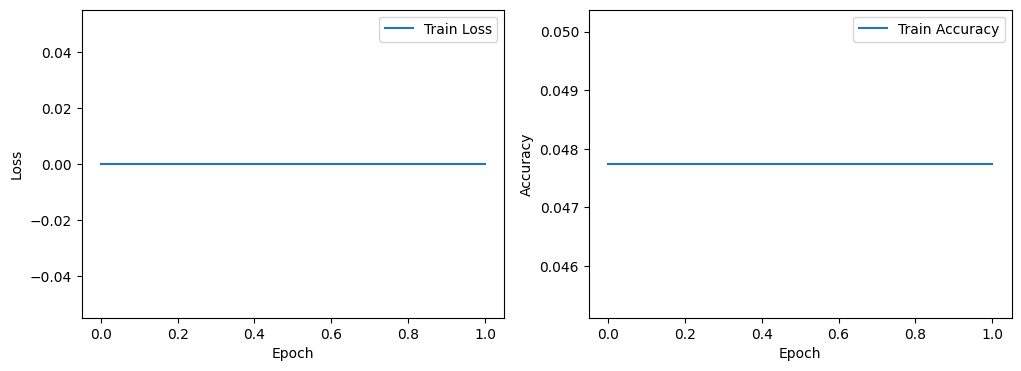

In [66]:
train_model(model, criterion, optimizer, train_loader, num_epochs, device)